- [0 Introduction](#0-Introduction)

In [618]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import Ridge as Ridge_Reg
from sklearn.linear_model import Lasso as Lasso_Reg
from sklearn.linear_model import LogisticRegression as Logit
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DecisionTree
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.preprocessing import LabelEncoder as LabelEncoder
import sklearn.preprocessing as Preprocessing
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler as Standardize
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split


import itertools as it
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import scipy as sp
from scipy import stats
from itertools import combinations



from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from collections import defaultdict


%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# 0 Introduction

## Project Overview

## Motivation

# 1 Data 

## 1.1 Lending Club Data

Lending Club loan data is available at https://www.lendingclub.com/info/download-data.action. In this project I used the data of loans issued in the first three quarters in 2016. I uploaded this data to the project github page under 'data/LoanStats_securev1_2016Q1.csv', 'LoanStats_securev1_2016Q2.csv', and 'data/LoanStats_2016Q3.csv'. For each loan, 115 features are provided and the description of the features is under 'data/LCDataDictionary.xlsx'.

In [620]:
data1 = pd.read_csv("./data/orig_data/LoanStats_securev1_2016Q1.csv", skiprows = 1)
data2 = pd.read_csv("./data/orig_data/LoanStats_securev1_2016Q2.csv", skiprows = 1)
data3 = pd.read_csv("./data/orig_data/LoanStats_2016Q3.csv", skiprows = 1)
## concatenate datasets into one dataset
data_all = pd.concat((data1, data2, data3), axis = 0, ignore_index=True)

In [621]:
data_all.shape

(330867, 115)

### 1.1.1 Loan Status

A total of 330867 loans were issued by lending club in the first three quarters of year 2016. The loans might have one of several status such as "Current", "Fully Paid", "Charged Off", etc. I treated the "Current" status as unknown status, and focus on the loans with known status that are either "Fully Paid" (meaning non-default) or "Default" (including "Charged Off", "Late", "In Grace Period", "Does not meet the credit policy", "Default"). I assigned the value of 1 to the default loans and the value of 0 to non-default loans.

In [27]:
data_all['loan_status'].value_counts()

Current               305952
Fully Paid             16318
Late (31-120 days)      3547
In Grace Period         2982
Late (16-30 days)       1160
Charged Off              881
Default                   21
Name: loan_status, dtype: int64

In [539]:
## remove "current status"
data = data_all[data_all['loan_status']!= 'Current']

## remove observations with unknown (NaN) loan status
data = data[data['loan_status'] == data['loan_status']]

# y == 1 if default, y == 0 if fully paid
y = np.ones(data.shape[0])
y[data['loan_status'].values =='Fully Paid'] = 0

total_default = len(y[y==1])
total_non_default = len(y[y==0])
print "The number of defaulted loans is", total_default, ", and the number of non-default loans is", total_non_default

The number of defaulted loans is 8591 , and the number of non-default loans is 16318


In [540]:
# save response values to 'lc_response.csv'
np.savetxt("lc_response.csv", y, delimiter=",")

In [541]:
## x get a copy of data
x = data[:]

### 1.1.2 Missing Data

I dropped variables with more than 10% missing values in the data set. For the rest missing data, I used scikit-learn impute function to fill the missing data with the mean of the variable in the whole data set.

In [542]:
too_many_missing = []
for column in x.columns:
    if (x[column].isnull().sum() >0.1*x.shape[0]):
        too_many_missing.append(column)
print "The number of variables deleted due to too many massing values is", len(too_many_missing)
x = x.drop(too_many_missing, axis = 1)

The number of variables deleted due to too many massing values is 15


### 1.1.3 Transform String Variables

The variable "issue_d" is a string containing the issue year and month of the loans. I created two variables of 'issue_y' and 'issue_m' and deleted the variable "issue_d". Same as string variable 'earliest_cr_line', 'revol_util'

In [543]:
## generate year variable
x['issue_y'] = x['issue_d'].str[4:]

## generate month variable
x['issue_m'] = x['issue_d'].str[:3]

x = x.drop(['issue_d'], axis = 1)

In [544]:
x['cr_y'] = x['issue_y'].apply(lambda k: float(k)) - x['earliest_cr_line'].str[4:].apply(lambda k: float(k))
x['revol_util'] = x['revol_util'].apply(lambda k: float(str(k).strip('%'))/100)

x = x.drop(['earliest_cr_line'], axis = 1)

### 1.1.4 Variables with Constant Values

1. 
There might be variables with constant values in the data set, which have no use in predicting the loan outcomes. Therefore I checked the number of unique values for each variable in the data set and deleted the constant variables.
2. 
There might be variables that have valid meaning for default loans only and have no meaning for non-default loans (for example, "collection_recovery_fee"), or vice versa. These variables are strongly associated with the loan outcomes. Therefore, we cannot use them as predictors of loan status, but should not be used as predictors of loan outcomes since they are essentially variable of loan outcomes. Therefore I also deleted variables with constant values for all default loans or with constant values for all non-default loans.


In [545]:
## look at the unique values of each variable in the entire dataset
unique_values = [] 
for column in x.columns:
    
    ## get unique values of variables
    unique = len(x[column].unique())
    if unique == 1:
        print column, "has a constant value for all observations."
    ## append the unique value to unique_values list
    unique_values.append(unique)

#print "The numbers of unique values of corresponding variables are", unique_values

policy_code has a constant value for all observations.
pymnt_plan has a constant value for all observations.
issue_y has a constant value for all observations.


In [546]:
x = x.drop(['policy_code', 'pymnt_plan', 'issue_y'], axis = 1)

In [547]:
## look at the unique values of each variable by loan status
unique_values_by_status = pd.DataFrame({}) 
for column in x.columns:
    
    ## get unique values of variables grouped by loan status
    unique = pd.Series((len(x[column][y == 0].unique()), len(x[column][y == 1].unique())))
    
    if len(x[column][y == 0].unique()) == 1:
        print column, "only valid for default loans"
        
    if len(x[column][y == 1].unique()) == 1:
        print column, "only valid for non-default loans"
    ## append the unique value series to unique_values_by_status dataframe
    unique_values_by_status = pd.concat([unique_values_by_status, unique], axis=1)

collection_recovery_fee only valid for default loans
loan_status only valid for default loans
out_prncp only valid for default loans
out_prncp_inv only valid for default loans
recoveries only valid for default loans


In [548]:
x = x.drop(['collection_recovery_fee', 'out_prncp', 'out_prncp_inv', 'recoveries'], axis = 1)

### 1.1.5 Meaningless Non-predictors

Delete variables that are not meaningful and thus do not contribute to the prediction of loan outcome.

In [549]:
## Drop non-predictors and keep valid predictors only
x = x.drop(['member_id', 'id', 'url', 'emp_title'], axis = 1, inplace = False)

###  1.1.6 "Post-hoc" Variables

"Post-hoc" variables are variables that are not available until the issuance of the loans, such as principle received up to today. Since we are predicting the loan outcomes to decide whether or not to lend the money, we need to make the decision with avaialble information before the issuance of loans. Therefore I went through the documentation and discovered all the "post-hoc" variables. Including the "post-hoc" variables as predictors gave me perfect predicting accuracy (around 98%), but in practical it makes no sense to include the post-hoc information in prediction model, so I excluded all the post-hoc variables.

In [550]:
x = x.drop(['total_pymnt', 'total_pymnt_inv', 'last_pymnt_amnt','last_pymnt_d', 'total_rec_int', 'total_rec_late_fee', 'last_credit_pull_d', 'total_rec_prncp'], axis = 1)

### 1.1.7 Third-party Credit Score

The Lending Club data set also include FICO scores of the borrowers and Lending Club credit grade of the loans. Since the credit score and grade are artificially generated by human beings trying to predict the default probability of the loans, these features are not available from the raw data of borrowers and loans. 

Since the goal of this project is to predict the outcomes of loans, it makes sense to exclude the credit grade as predictors and use only raw information of loans and borrowers. Similarly, the interest rate of loans should be excluded because it is also a reflection of the default probability of the loans.

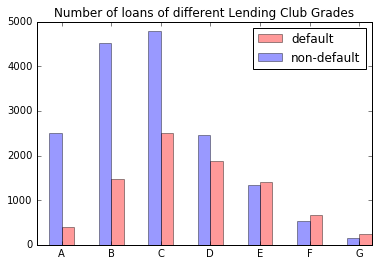

In [551]:
ax1 = plt.subplot()
grade_default = x[y == 1].grade.copy()
grade_default.sort()
grade_default.reset_index(drop=True)
grade_non_default = x[y == 0].grade.copy()
grade_non_default.sort()
grade_non_default.reset_index(drop=True)



grade_default.value_counts().sort_index().plot(kind='bar', color = 'red',alpha = 0.4, position=0, width=0.25, axes = ax1, label = 'default')
grade_non_default.value_counts().sort_index().plot(kind='bar', color = 'blue', alpha = 0.4, position=1, width=0.25, axes = ax1, label = 'non-default')

for tick in ax1.get_xticklabels():
        tick.set_rotation(360)      
        
        
plt.legend()
plt.title('Number of loans of different Lending Club Grades')
plt.show()

In [552]:
x = x.drop(['grade', 'sub_grade', 'int_rate'], axis = 1)

### 1.1.8 Drop highly-correlated variables

Among the left 80 features, some of them are highly-correlated. I plotted the correlation between each pair of the features and identify the features of high correlation. Then I deleted the highly-correlated features and keep only one representing to represent its peer features.

In [553]:
corr_m = x.corr()
# corr_m
high_corr = ['funded_amnt', 'funded_amnt_inv', 'installment']
x = x.drop(high_corr, axis = 1) 

### 1.1.9 Transform annual_inc to log measure

In [554]:
# plt.hist(x['annual_inc'])
# plt.clf()
x['annual_inc'] = np.log(x['annual_inc']+1)
# plt.hist(x['annual_inc'])

### 1.1.10 Trivial changes

In [555]:
data = data[x['home_ownership']!= 'ANY']
y = y[x['home_ownership'].values != 'ANY']
x = x[x['home_ownership']!= 'ANY']

## 1.2 Census Data

Census data by zip code available at http://www.psc.isr.umich.edu/dis/census/Features/tract2zip/index.html. I also uploaded this data to the project github page under 'data/MedianZIP-3.csv'.

I merged the Lending Club data with Census data by zipcode to extend the feature set with neighborhood average income (weighted by population).

In [556]:
####read zip data
zipdata = pd.read_csv("./data/MedianZIP-3.csv")

zipdata['3d'] = zipdata['Zip'].apply(lambda l: l/100)
zipdata['Average'] = zipdata['Mean']*zipdata['Pop']
### 887 zip in zipdata

zipagg = zipdata[['3d', 'Average']].groupby(['3d'], as_index=False).mean()

x['zip_code']  = x['zip_code'].apply(lambda l: int(l.strip('xx')))

x = pd.merge(x, zipagg, left_on=['zip_code'],
              right_on=['3d'],
              how='left')
x = x.drop(['3d', 'zip_code'], axis = 1)

## 1.3 Preprocessing Categorical Variables

I tried two ways to untanggle the categorical variable:

1. I expanded the categorical variables to dummies using on-hot-encode function of scikit-learn. The new feature data set is named 'x_exp', containing 163 features.
2. I encoded the categorical variables using scikit-learn function LabelEncoder(). The new feature data set is named 'x_encod' containint 75 features.

In [557]:
x_exp = pd.DataFrame({}) 
print "variables encoded to dummies:"
# Iterate over all attributes
for column in x.columns:
    # Check if attribute is categorical: has less than 8 unique values,
    # or is string values (column has type 'object')
#      (len(x[column].unique()) <10) & 
    if(column == 'loan_status'):
        continue
    if(x[column].dtype == np.dtype('object')):
        print column
        # use one-hot encoding for this column
        encoding = pd.get_dummies(x[column], drop_first = True)
        # append expanded attribute to data frame
        x_exp = pd.concat([x_exp, encoding], axis=1)
    else:
        x_exp = pd.concat([x_exp, x[[column]]], axis=1)
        
imputer = Imputer(strategy='most_frequent')
imputer.fit(x_exp)
x_temp = imputer.transform(x_exp)
x_exp = pd.DataFrame(x_temp, columns= x_exp.columns)

variables encoded to dummies:
addr_state
application_type
emp_length
home_ownership
initial_list_status
purpose
term
title
verification_status
issue_m


In [558]:
for column in x.columns:
    if x[column].dtype != 'object':
        x[column].fillna(x[column].mean(), inplace=True)
        
####Encode categorical variables

d = defaultdict(LabelEncoder)
#With this, you now retain all columns LabelEncoder as dictionary.
categorical_list = []
for column in x.columns:
    if x[column].dtype == 'object':
        categorical_list.append(column)
        
# Encoding the variable
x_encod = x.drop(['loan_status'], axis = 1).apply(lambda x: d[x.name].fit_transform(x) if x.name in categorical_list else x) 
x_exp.shape, x_encod.shape

((24908, 163), (24908, 75))

# 2. Analysis

## 2.1 Visualization and plots

### 2.1.1 Annual Income and Loan Amount

First I explored the relationship between loan amount and annual income, and plotted the relationship curves separately for different loan outcomes (default and non-default). For each range of loan amount and for two different loan outcomes, I calculate the average annual income of borrowers. I found that the two relationship curves far away from each other when the loan amount is relatively low, but converges together as loan amount exceeds 20000. Note that annual income has been transformed to log measure due to right skewness of distribution.

This result gives a very important hint: for small loans with amount less than 20000, borrower's annual income has a very important influence on loan outcome. However, for large loans with amount greater than 20000, borrower's annual income does not make a difference in loan outcome.

Generally, the red line lies below the blue line, indicating whatever the loan amount, the average annual income of non-defualt loan borrowers is higher than the default loan borrowers. This is consistent with our intuition.  

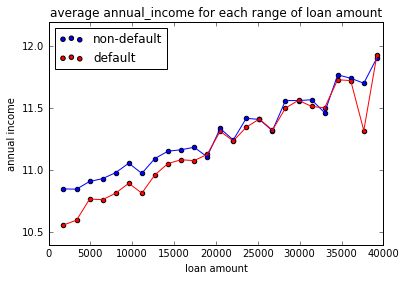

In [409]:
bin_means_0, bin_edges_0, binnumber_0 = stats.binned_statistic(x['loan_amnt'][y == 0], x['annual_inc'][y == 0], statistic='mean', bins=25)
bin_width_0 = (bin_edges_0[1] - bin_edges_0[0])
bin_centers_0 = bin_edges_0[1:] - bin_width_0/2

bin_means_1, bin_edges_1, binnumber_1 = stats.binned_statistic(x['loan_amnt'][(y == 1) & (x['annual_inc'].isnull().values == False)], x['annual_inc'][(y == 1)& (x['annual_inc'].isnull().values == False)], statistic='mean', bins=25)
bin_width_1 = (bin_edges_1[1] - bin_edges_1[0])
bin_centers_1 = bin_edges_1[1:] - bin_width_1/2

plt.scatter(bin_centers_0, bin_means_0, c= 'blue', label = 'non-default')
plt.plot(bin_centers_0, bin_means_0, c= 'blue')
plt.scatter(bin_centers_1, bin_means_1, c='red', label = 'default')
plt.plot(bin_centers_1, bin_means_1, c='red')

plt.title("average annual_income for each range of loan amount")
plt.xlabel('loan amount')
plt.ylabel('annual income')
plt.legend(loc = 2)
plt.xlim(0, 40000)
plt.show()

### 2.1.2 Debt to Income Ratio and Loan Amount

Then I plotted the relationship curves of debt to income ratio and loan amount by loan outcomes in the same way as 2.1.1. Debt to income ratio is also different for default and non-default loans for each range of loan amount. Generally the borrowers of loans that default have higher debt to income ratio than the borrowers whose loans did not default.

The two curves are clearly separated and parallel with each other when loan amount is small. However, as loan amount grows, the two curves converges to each other and even crosses over. This indicates that debt to income ratio might work well in separating the default and non-default loans for small amount loans, but for large amount loans, the influence of debt to income ratio on the loan outcome becomes trivial.

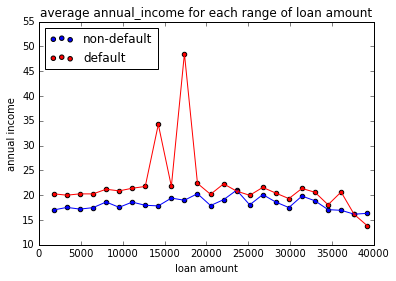

In [410]:
bin_means_0, bin_edges_0, binnumber_0 = stats.binned_statistic(x['loan_amnt'][y == 0], x['dti'][y == 0], statistic='mean', bins=25)
bin_width_0 = (bin_edges_0[1] - bin_edges_0[0])
bin_centers_0 = bin_edges_0[1:] - bin_width_0/2

bin_means_1, bin_edges_1, binnumber_1 = stats.binned_statistic(x['loan_amnt'][y == 1], x['dti'][y == 1], statistic='mean', bins=25)
bin_width_1 = (bin_edges_1[1] - bin_edges_1[0])
bin_centers_1 = bin_edges_1[1:] - bin_width_1/2

plt.scatter(bin_centers_0, bin_means_0, c= 'blue', label = 'non-default')
plt.plot(bin_centers_0, bin_means_0, c= 'blue')
plt.scatter(bin_centers_1, bin_means_1, c='red', label = 'default')
plt.plot(bin_centers_1, bin_means_1, c='red')

plt.title("average annual_income for each range of loan amount")
plt.xlabel('loan amount')
plt.ylabel('annual income')
plt.legend(loc = 2)
plt.xlim(0, 40000)
plt.show()

### 2.1.3 Home Ownership

The type of home ownership might also be related with loan outcomes, since different home ownership might be an indication of the borrower's financial situation and influence the cash flow capability of the borrowers.

From the results we can find that the "RENT" type of ownership has the highest proportion of default loans, while "MORTGAGE" type of ownership has the lowest. This makes sense because people who choose to apply for mortgage and got approved are those with good credit history and stable income cash flows compared to people who rent to live. 

The proportion of default by different types of home ownership is:
MORTGAGE    0.298404
OWN         0.329897
RENT        0.410831
Name: home_ownership, dtype: float64


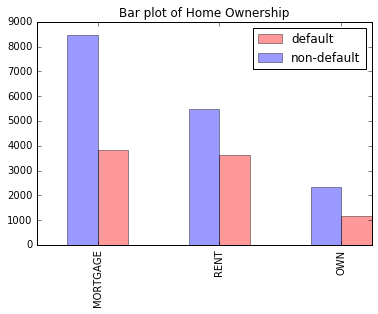

In [411]:
## one observation with home_ownership == any, drop it
# y = y[x['home_ownership'].values != 'ANY']
# x = x[x['home_ownership']!= 'ANY']

print "The proportion of default by different types of home ownership is:"
print x[y == 1].home_ownership.value_counts()/(x[y == 1].home_ownership.value_counts() + x[y == 0].home_ownership.value_counts())
ax1 = plt.subplot()
x[y == 1].home_ownership.value_counts().plot(kind='bar', color = 'red', position=0,width=0.25,alpha = 0.4, axes = ax1, label = 'default')
x[y == 0].home_ownership.value_counts().plot(kind='bar', color = 'blue',position=1,width=0.25, alpha = 0.4, axes = ax1, label = 'non-default')


plt.legend()
plt.title('Bar plot of Home Ownership')
plt.show()

In [413]:
x = x.drop(['loan_status'], axis = 1)
x_copy = x[:]

## 2.2 Feature Selection

Before conducting feature selection, I split the whold data set into training and testing data sets to avoid fitting to the test data set.

In [414]:
X_train, X_test, y_train, y_test = train_test_split(x_encod, y, test_size=0.3)

In [415]:
def recall(y, y_hat):
    score = np.mean(y_hat[y == 1])
    return score

def precision(y, y_hat):
    score = np.mean(y[y_hat == 1])
    return score

def F_score(y, y_hat):
    prec = precision(y,y_hat)
    rec = recall(y, y_hat)
    score = 2*(prec*rec)/(prec+rec)
    return score

### 2.2.1 Lasso Regularization

First I use logistic regression with Lasso regularization with different penaly hyper-parameters C. Smaller C means stricter regularization and fewer non-zero parameter features. There is a trade-off between bias and variance: models with fewer features tend to be robust to changes of data, but with more classification error; models with more features are more flexible and good at fitting the training data, but tend to be volatile and sensitivity to changes in data set. There is a "sweet point" in-between such that a model gives good performance results with appropriate number of predictors.

I drew the ROC curves of all the logistic models with different C-parameters, and based on the analysis of Logistic regression results and ROC curves, I found the "sweet point" with C = 0.001 and 28 non-zero parameter predictors.

In [417]:
Cs = [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]

fpr = [0]*len(Cs)
tpr = [0]*len(Cs)

for i in range(len(Cs)):
    features = []
    C = Cs[i]
    print "penalty C is", C
    logit = Logit(penalty='l1', C=C)
    
    logit.fit(X_train, y_train)
    coefs = logit.coef_

    
    #### predict y_hat
    y_hat = logit.predict(X_train)
    
    #### draw ROC 
    y_pred_logit = logit.predict_proba(X_train)[:, 1]
    fpr[i], tpr[i], _ = roc_curve(y_train, y_pred_logit)
    
    #### display the predictors with non-zero parameters
    count = 0
    for k in range(len(coefs[0])):
        if coefs[0][k] != 0:
            features.append(X_train.columns.values[k])
            count+=1
    print "Number of non-zero parameters is", count
    print features
    print "accuracy rate is", logit.score(X_train, y_train)
    print "recall rate is", recall(y_train, y_hat)
    print "precision rate is", precision(y_train, y_hat)
    print "F score is", F_score(y_train, y_hat)
    print "AUC score is", roc_auc_score(y_train, y_pred_logit)
    print

penalty C is 1
Number of non-zero parameters is 75
['acc_now_delinq', 'acc_open_past_24mths', 'addr_state', 'all_util', 'annual_inc', 'application_type', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collections_12_mths_ex_med', 'delinq_2yrs', 'delinq_amnt', 'dti', 'emp_length', 'home_ownership', 'initial_list_status', 'inq_fi', 'inq_last_12m', 'inq_last_6mths', 'loan_amnt', 'max_bal_bc', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_rcnt_il', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'open_acc', 'open_acc_6m', 'open_il_12m', 'open_il_24m', 'open_il_6m', 'open_rv_12m', 'open_rv_24m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec', 'pub_re

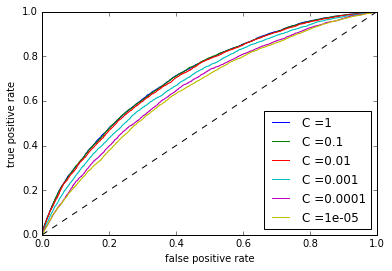

In [418]:
for i in range(len(Cs)):
    plt.plot(fpr[i], tpr[i], label= 'C =' + str(Cs[i]))

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc = 4)
plt.show()

### 2.2.2 Random Forest Feature Importance

In [455]:
####k-folds cross validation

X_train_sel = X_train
X_test_sel = X_test

n_obs = X_train.shape[1]
#Parameters for tuning
n_trees = np.arange(200, 800, 100)  # Trees and depth are explored on an exponentially growing space,
depths = np.arange(4, 10, 2)   # since it is assumed that trees and depth will add accuracy in a decaying fashion.

# To keep track of the best model
best_score = 0
best_recall = 0
best_auc = 0

# Run grid search for model with 5-fold cross validation
print '5-fold cross validation:'

for trees in n_trees:
    for depth in depths:
        
        # Cross validation for every experiment
        kf = KFold(n_obs, 5, shuffle = True)
        scores = []
        recalls = []
        auc = []
        for train_indices, validation_indices in kf:
            # Generate training data
            x_train_cv = X_train_sel.iloc[train_indices, :]
            y_train_cv = y_train[train_indices]
            
#             print x_train_cv.shape, y_train_cv.shape
            # Generate validation data
            x_validate = X_train_sel.iloc[validation_indices, :]
            y_validate = y_train[validation_indices]
            
            # Fit random forest on training data
            rf = RandomForest(n_estimators=trees, max_depth=depth)
            rf.fit(x_train_cv, y_train_cv)
            # Score on validation data
            scores += [rf.score(x_validate, y_validate)]
            y_hat_validate = rf.predict(x_validate)
            recalls += [recall(y_validate, y_hat_validate)]
            
            y_pred_logit = rf.predict_proba(x_validate)[:, 1]
            auc += [roc_auc_score(y_validate, y_pred_logit)]
        # Record and report accuracy
        average_score = np.mean(scores)
        recall_rate = np.mean(recalls)
        avg_auc = np.mean(auc)
        print "Trees:", trees, "Depth:", depth, "Score:", average_score, "AUC", avg_auc
        
        # Update our record of the best parameters see so far
        if average_score > best_score:
            best_score = average_score
            best_trees = trees
            best_depth = depth
        if avg_auc > best_auc:
            best_auc = avg_auc
            best_auc_trees = trees
            best_auc_depth = depth
print 'number of trees, depth Chosen by Accuracy:', best_trees, ',', best_depth, ',', best_score
print 'number of trees, depth Chosen by AUC:', best_auc_trees, ',', best_auc_depth, ',', best_auc

5-fold cross validation:
Trees: 200 Depth: 4 Score: 0.56 AUC 0.60412987013
Trees: 200 Depth: 6 Score: 0.626666666667 AUC 0.653810966811
Trees: 200 Depth: 8 Score: 0.546666666667 AUC 0.579725348725
Trees: 300 Depth: 4 Score: 0.6 AUC 0.69012047212
Trees: 300 Depth: 6 Score: 0.64 AUC 0.645214045214
Trees: 300 Depth: 8 Score: 0.546666666667 AUC 0.710512820513
Trees: 400 Depth: 4 Score: 0.546666666667 AUC 0.689032967033
Trees: 400 Depth: 6 Score: 0.586666666667 AUC 0.665703703704
Trees: 400 Depth: 8 Score: 0.573333333333 AUC 0.657996632997
Trees: 500 Depth: 4 Score: 0.6 AUC 0.690211640212
Trees: 500 Depth: 6 Score: 0.56 AUC 0.616391534392
Trees: 500 Depth: 8 Score: 0.6 AUC 0.651641173641
Trees: 600 Depth: 4 Score: 0.586666666667 AUC 0.697899470899
Trees: 600 Depth: 6 Score: 0.613333333333 AUC 0.694444444444
Trees: 600 Depth: 8 Score: 0.546666666667 AUC 0.637094276094
Trees: 700 Depth: 4 Score: 0.56 AUC 0.633405483405
Trees: 700 Depth: 6 Score: 0.626666666667 AUC 0.65266955267
Trees: 700 Dep

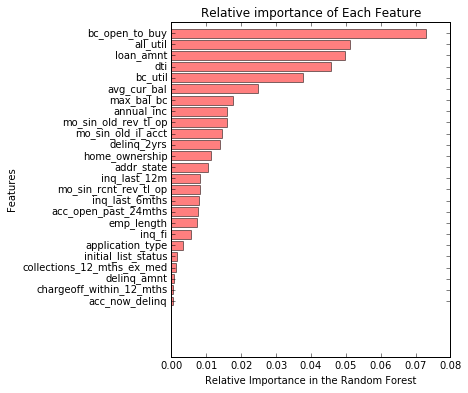

('acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt', 'collections_12_mths_ex_med', 'initial_list_status', 'application_type', 'inq_fi', 'emp_length', 'acc_open_past_24mths', 'inq_last_6mths', 'mo_sin_rcnt_rev_tl_op', 'inq_last_12m', 'addr_state', 'home_ownership', 'delinq_2yrs', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'annual_inc', 'max_bal_bc', 'avg_cur_bal', 'bc_util', 'dti', 'loan_amnt', 'all_util', 'bc_open_to_buy')


In [456]:
# Fit model on entire train set using chosen number of trees and depth
rf = RandomForest(n_estimators=300, max_depth=8, min_samples_split = 10)
rf.fit(X_train_sel,y_train)

importance_list = rf.feature_importances_
name_list = X_train_sel.columns
importance_list, name_list = zip(*sorted(zip(importance_list[:25], name_list[:25])))
plt.figure(figsize=(5, 6))
plt.barh(range(len(name_list)),importance_list,align='center', color = 'red', alpha = 0.5)
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()
print name_list

### 2.2.3 Step-wise Backward Feature Selection

In [464]:
bcwd_list = ['acc_open_past_24mths', 'addr_state', 'all_util', 'avg_cur_bal', 'bc_open_to_buy', 
             'bc_util', 'delinq_amnt', 'dti', 'loan_amnt', 'max_bal_bc', 'mo_sin_old_il_acct', 'mo_sin_rcnt_tl',
             'mths_since_rcnt_il', 'mths_since_recent_inq', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'revol_bal', 
             'tot_coll_amt', 'tot_cur_bal', 'tot_hi_cred_lim', 'total_acc', 'total_bal_ex_mort', 'total_bal_il',
             'total_bc_limit', 'total_cu_tl', 'total_il_high_credit_limit', 'total_rev_hi_lim', 'Average',
             'acc_now_delinq',  'chargeoff_within_12_mths',  'initial_list_status',  'collections_12_mths_ex_med',
             'application_type',  'inq_fi',  'mo_sin_rcnt_rev_tl_op',  'emp_length',  'inq_last_12m', 
             'inq_last_6mths',  'annual_inc',  'delinq_2yrs',  'home_ownership',]

X_sel_train = X_train[bcwd_list]
X_sel_test = X_test[bcwd_list]

In [467]:
###  Step-wise Backward Selection
d = X_sel_train.shape[1] # total no. of predictors

# Keep track of current set of chosen predictors
current_predictors = range(d)

# Keep track of the best subset of predictors
best_subset = [] 

# Iterate over all possible subset sizes, d predictors to 1 predictor
for size in range(d - 1, 0, -1): # stop before 0 to avoid choosing an empty set of predictors
    max_auc = -1e10 # set some initial small value for max R^2
    worst_predictor = -1 # set some throwaway initial number for the worst predictor to remove
    
    print size
    
    # Iterate over current set of predictors (for potential elimination)
    for i in current_predictors:
        # Create copy of current predictors, and remove predictor 'i'
        temp = current_predictors[:]
        temp.remove(i)
                                    
        # Use only a subset of predictors in the training data
        x_subset = X_sel_train.values[:, temp]
        
         # Fit and evaluate recall
        logit.fit(x_subset, y_train)

        y_pred_logit = logit.predict_proba(x_subset)[:, 1]
        auc = roc_auc_score(y_train, y_pred_logit)
        
        # Check if we get a higher AUC than current max AUC, if so, update
        if(auc > max_auc):
            max_auc = auc
            worst_predictor = i
    # Remove worst predictor from current set of predictors
    current_predictors.remove(worst_predictor)
    print [features[i] for i in current_predictors], max_auc

40
['acc_open_past_24mths', 'addr_state', 'all_util', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'delinq_amnt', 'dti', 'loan_amnt', 'max_bal_bc', 'mo_sin_old_il_acct', 'mo_sin_rcnt_tl', 'mths_since_rcnt_il', 'mths_since_recent_inq', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'revol_bal', 'tot_coll_amt', 'tot_cur_bal', 'tot_hi_cred_lim', 'total_acc', 'total_bal_ex_mort', 'total_bal_il', 'total_bc_limit', 'total_cu_tl', 'total_il_high_credit_limit', 'total_rev_hi_lim', 'acc_now_delinq', 'chargeoff_within_12_mths', 'initial_list_status', 'collections_12_mths_ex_med', 'application_type', 'inq_fi', 'mo_sin_rcnt_rev_tl_op', 'emp_length', 'inq_last_12m', 'inq_last_6mths', 'annual_inc', 'delinq_2yrs', 'home_ownership'] 0.656115693457
39
['acc_open_past_24mths', 'addr_state', 'all_util', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'delinq_amnt', 'dti', 'loan_amnt', 'max_bal_bc', 'mo_sin_old_il_acct', 'mo_sin_rcnt_tl', 'mths_since_rcnt_il', 'mths_since_recent_inq', 'pct_tl_nvr_dlq', 'percent_bc_gt_7

### 2.2.4 Features Selection Conclusion

Based on the three feature selection methods and analysis of each features, the predictors I choose to continue with include:
'loan_amnt','term', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'purpose',
  'title', 'addr_state','delinq_2yrs', 'open_acc', 'revol_util','open_acc_6m', 'open_il_12m', 'total_cu_tl',  'mo_sin_old_il_acct', 'mort_acc',   'mths_since_recent_bc', 'num_actv_rev_tl', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'avg_cur_bal','bc_open_to_buy','total_rev_hi_lim', 'revol_bal'.

In [471]:
feature = ['loan_amnt','term', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'purpose',
          'title', 'addr_state','delinq_2yrs', 'open_acc', 'revol_util','open_acc_6m', 'open_il_12m', 
           'total_cu_tl', 'mo_sin_old_rev_tl_op',  'mort_acc',   'mths_since_recent_bc',
          'num_actv_rev_tl', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'avg_cur_bal','bc_open_to_buy','total_rev_hi_lim',
           'revol_bal']
len(feature)

25

# 3. Classification

## 3.1 Performance Evaluation Metrics

I defined a function called "predict_table", which returns a comprehensive table of the classification results including True(False) Positive(Nagative) predictions as well as recall and precisions on default (class 1) and non-default (class 0) groups. Also I calculated the Accuracy and AUC of the classification results and "Pass rate" defined as the proportion of predicted non-default loans among all of the loans. All of the evaluation metrics are calculated on test data set

In [478]:
def predict_table(y, y_hat):
    tp = 0.0
    tn = 0.0
    fp = 0.0
    fn = 0.0
    for i in range(len(y)):
        if(y[i] == 1 and y_hat[i] == 1):
            tp += 1.0
        elif(y[i] == 0 and y_hat[i] == 0):
            tn += 1.0
        elif(y[i] == 1 and y_hat[i] == 0):
            fn += 1.0
        elif(y[i] == 0 and y_hat[i] == 1):
            fp += 1.0
        else:
            print "Something is wrong with labels!"
    print "Total number of test data: " + str(len(y))
    print "True  Positive:            " + str(tp)
    print "True  Negative:            " + str(tn)
    print "False Positive:            " + str(fp)
    print "False Negative:            " + str(fn)
    print "Recall    on class 1:      " + str(tp/(tp + fn))
    print "Precision on class 1:      " + str(tp/(tp + fp))
    print "Recall    on class 0:      " + str(tn/(tn + fp))
    print "Precision on class 0:      " + str(tn/(tn + fn))
    print "Accuracy:                  " + str((tp + tn)/len(y))
    print "Pass rate:            " + str((tn + fn)/len(y))
#     return (tn + fn)/len(y), (tp + tn)/len(y), tp/(tp + fn), tn/(tn + fn)

With the predictors I selected in the last step, I tried to classify the loans to "default" and "non-default" with different classification models: Logistic Regression, LDA and QDA, Random Forest, and Gradient Boost.

In [559]:
X_sel_train = X_train[feature]
X_sel_test = X_test[feature]

## 3.2 Classification Models

### 3.2.1 Logistic Regression Model 

In [504]:
clf_slc = Logit()
clf_slc.fit(X_train_sel, y_train)
y_predict_slc = clf_slc.predict(X_test_sel)
y_predict_prob_slc = clf_slc.predict_proba(X_test_sel)[:,1]

fpr_slc, tpr_slc, _ = roc_curve(y_test, y_predict_prob_slc)

print "**************************************************"
print " Sklearn logistic regression Model performance report"
print "**************************************************"
predict_table(y_test, y_predict_slc)
print "auc score = ", roc_auc_score(y_test, y_predict_prob_slc)

**************************************************
 Sklearn logistic regression Model performance report
**************************************************
Total number of test data: 7473
True  Positive:            399.0
True  Negative:            4541.0
False Positive:            348.0
False Negative:            2185.0
Recall    on class 1:      0.154411764706
Precision on class 1:      0.534136546185
Recall    on class 0:      0.92881979955
Precision on class 0:      0.675141242938
Accuracy:                  0.661046433828
Pass rate:            0.90004014452
auc score =  0.654660316614


### 3.2.2 LDA and QDA

In [482]:
clf_lda = LDA()
clf_lda.fit(X_train_sel, y_train)
y_predict_lda = clf_lda.predict(X_test_sel)
y_predict_prob_lda = clf_lda.predict_proba(X_test_sel)[:,1]

fpr_lda, tpr_lda, _ = roc_curve(y_test, y_predict_prob_lda)

clf_qda = QDA()
clf_qda.fit(X_train_sel, y_train)
y_predict_qda = clf_qda.predict(X_test_sel)
y_predict_prob_qda = clf_qda.predict_proba(X_test_sel)[:,1]

fpr_qda, tpr_qda, _ = roc_curve(y_test, y_predict_prob_qda)


print "**************************************************"
print " LDA Model performance report"
print "**************************************************"
predict_table(y_test, y_predict_lda)
print "auc score = ", roc_auc_score(y_test, y_predict_prob_lda)

print "**************************************************"
print " QDA performance report"
print "**************************************************"
predict_table(y_test, y_predict_qda)
print "auc score = ", roc_auc_score(y_test, y_predict_prob_qda)

**************************************************
 LDA Model performance report
**************************************************
Total number of test data: 7473
True  Positive:            813.0
True  Negative:            4325.0
False Positive:            564.0
False Negative:            1771.0
Recall    on class 1:      0.314628482972
Precision on class 1:      0.590413943355
Recall    on class 0:      0.884638985478
Precision on class 0:      0.709481627297
Accuracy:                  0.687541817209
Pass rate:            0.815736651947
auc score =  0.696830789027
**************************************************
 QDA performance report
**************************************************
Total number of test data: 7473
True  Positive:            450.0
True  Negative:            4429.0
False Positive:            460.0
False Negative:            2134.0
Recall    on class 1:      0.174148606811
Precision on class 1:      0.494505494505
Recall    on class 0:      0.90591122929
Precision 

### 3.2.3 Random Forest

In [486]:
X_train_sel = X_train[feature]
X_test_sel = X_test[feature]

n_obs = X_train.shape[1]
#Parameters for tuning
n_trees = np.arange(200, 800, 100)  # Trees and depth are explored on an exponentially growing space,
depths = np.arange(4, 10, 2)   # since it is assumed that trees and depth will add accuracy in a decaying fashion.

# To keep track of the best model
best_score = 0
best_recall = 0
best_auc = 0

# Run grid search for model with 5-fold cross validation
print '5-fold cross validation:'

for trees in n_trees:
    for depth in depths:
        
        # Cross validation for every experiment
        kf = KFold(n_obs, 5, shuffle = True)
        scores = []
        recalls = []
        auc = []
        for train_indices, validation_indices in kf:
            # Generate training data
            x_train_cv = X_train_sel.iloc[train_indices, :]
            y_train_cv = y_train[train_indices]
            
#             print x_train_cv.shape, y_train_cv.shape
            # Generate validation data
            x_validate = X_train_sel.iloc[validation_indices, :]
            y_validate = y_train[validation_indices]
            
            # Fit random forest on training data
            rf = RandomForest(n_estimators=trees, max_depth=depth)
            rf.fit(x_train_cv, y_train_cv)
            # Score on validation data
            scores += [rf.score(x_validate, y_validate)]
            y_hat_validate = rf.predict(x_validate)
            recalls += [recall(y_validate, y_hat_validate)]
            
            y_pred_logit = rf.predict_proba(x_validate)[:, 1]
            auc += [roc_auc_score(y_validate, y_pred_logit)]
        # Record and report accuracy
        average_score = np.mean(scores)
        recall_rate = np.mean(recalls)
        avg_auc = np.mean(auc)
        print "Trees:", trees, "Depth:", depth, "Score:", average_score, "AUC", avg_auc
        
        # Update our record of the best parameters see so far
        if average_score > best_score:
            best_score = average_score
            best_trees = trees
            best_depth = depth
        if avg_auc > best_auc:
            best_auc = avg_auc
            best_auc_trees = trees
            best_auc_depth = depth
print "Best number of trees and best tree depth according to accuracy is", best_trees, best_depth
print "Best number of trees and best tree depth according to AUC is", best_auc_trees, best_auc_depth

5-fold cross validation:
Trees: 200 Depth: 4 Score: 0.613333333333 AUC 0.781481481481
Trees: 200 Depth: 6 Score: 0.693333333333 AUC 0.768759018759
Trees: 200 Depth: 8 Score: 0.68 AUC 0.710185185185
Trees: 300 Depth: 4 Score: 0.68 AUC 0.81319047619
Trees: 300 Depth: 6 Score: 0.613333333333 AUC 0.747857142857
Trees: 300 Depth: 8 Score: 0.653333333333 AUC 0.674777777778
Trees: 400 Depth: 4 Score: 0.626666666667 AUC 0.776
Trees: 400 Depth: 6 Score: 0.653333333333 AUC 0.710206349206
Trees: 400 Depth: 8 Score: 0.613333333333 AUC 0.697873015873
Trees: 500 Depth: 4 Score: 0.6 AUC 0.69407022607
Trees: 500 Depth: 6 Score: 0.64 AUC 0.746682539683
Trees: 500 Depth: 8 Score: 0.72 AUC 0.754586580087
Trees: 600 Depth: 4 Score: 0.666666666667 AUC 0.732347282347
Trees: 600 Depth: 6 Score: 0.653333333333 AUC 0.728646353646
Trees: 600 Depth: 8 Score: 0.613333333333 AUC 0.727018352018
Trees: 700 Depth: 4 Score: 0.586666666667 AUC 0.67904040404
Trees: 700 Depth: 6 Score: 0.706666666667 AUC 0.742779220779
T

In [491]:
rf = RandomForest(n_estimators = 300, max_depth = 8, random_state = 8)
rf.fit(X_train_sel, y_train)

y_predict_rf = rf.predict(X_test_sel)
y_predict_prob_rf = rf.predict_proba(X_test_sel)[:,1]

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_predict_prob_rf)


print "**************************************************"
print " Random Forest Model performance report"
print "**************************************************"
predict_table(y_test, y_predict_rf)
print "auc score = ", roc_auc_score(y_test, y_predict_prob_rf)

**************************************************
 Random Forest Model performance report
**************************************************
Total number of test data: 7473
True  Positive:            456.0
True  Negative:            4645.0
False Positive:            244.0
False Negative:            2128.0
Recall    on class 1:      0.176470588235
Precision on class 1:      0.651428571429
Recall    on class 0:      0.950092043363
Precision on class 0:      0.685811309612
Accuracy:                  0.682590659708
Pass rate:            0.906329452696
auc score =  0.69099045244


### 3.2.4 Gradient Boost

In [498]:
# Set the parameters by cross-validation
tuned_parameters = [{'n_estimators': [50, 100, 200], 'learning_rate': [1.0, 5.0, 10.0], 'max_depth': [1, 3, 5]}]

scores = ['recall']
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(GradientBoostingClassifier(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train_sel, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
   
    print()

# Tuning hyper-parameters for recall
()
Best parameters set found on development set:
()
{'n_estimators': 100, 'learning_rate': 1.0, 'max_depth': 1}
()


In [500]:
clf_boost = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_boost.fit(X_train_sel, y_train)
y_predict_boost = clf_boost.predict(X_test_sel)
y_predict_prob_boost = clf_boost.predict_proba(X_test_sel)[:,1]


fpr_boost, tpr_boost, _ = roc_curve(y_test, y_predict_prob_boost)

print "**************************************************"
print "Boosting Model performance report"
print "**************************************************"
predict_table(y_test, y_predict_boost)
print "auc score = ", roc_auc_score(y_test, y_predict_prob_boost)

**************************************************
Boosting Model performance report
**************************************************
Total number of test data: 7473
True  Positive:            853.0
True  Negative:            4249.0
False Positive:            640.0
False Negative:            1731.0
Recall    on class 1:      0.330108359133
Precision on class 1:      0.571332886805
Recall    on class 0:      0.86909388423
Precision on class 0:      0.710535117057
Accuracy:                  0.682724474776
Pass rate:            0.800214104108
auc score =  0.69267316469


### 3.2.5 Comparison of Different Models

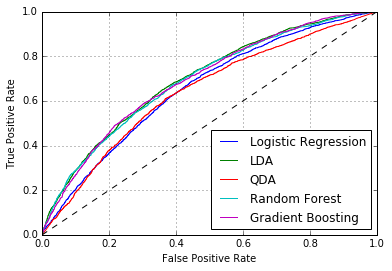

In [505]:
plt.plot(fpr_slc, tpr_slc, label = 'Logistic Regression')
plt.plot(fpr_lda, tpr_lda, label = 'LDA')
plt.plot(fpr_qda, tpr_qda, label = 'QDA')
plt.plot(fpr_rf, tpr_rf, label = 'Random Forest')
plt.plot(fpr_boost, tpr_boost, label = 'Gradient Boosting')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc = 'best')
plt.grid('on')
plt.savefig('roc-models.png')

From the curves above we can find that LDA, Random Forest, Gradient Boosting have similar performace and the ROC's are mostly overlapping with each other. QDA and Logistic Regression underperform the other three models. 

The fact that Random Forest and Gradient Boosting have outstanding performance compared to the other classification  models is not surprising to me. Actually, the ensemble models usually outperform single classification models in the real world, especially when there are many features and each feature's predicting power is very weak.

The fact the LDA outperform QDA is likely due to the excessive flexibility of the covariance matrix in QDA. The high flexibility of QDA is very likely to result in over-fitting the training data and worsen the results on testing data set.

## 3.3 Performance Improvements

The pass rate in the above models are all very high, meaning that most of the loans in the testing data set are predicted to be non-default. This is because the default and non-default loans in the data set is unbalanced with about 65% non-default loans and 35% default loans. Note that the percentage of default loans (35%) seems higher than usual, which is because I excluded the loans with "Current" status at the very beginning. It is expected that the percentage of default loans among "Current" loans will be much lower, because as time goes on, larger proportion of principles will be paid back, so people will have low motivation and less financial pressure to default on the loan.

The extremely high pass rate (proportion of predicted non-default loans) is the result of the prevalence of non-default loans in the data set. A classification model with high pass rate, although might make accuracy rate look good, hurts the investors because of the low precision on predicted non-default loans. Recall on default loans (among the actual default loans, what percentage of them are predicted to be default) as well as the precision on predicted non-default loans (among the predicted non-default loans, what percentage of them actually did not default) are two metrics closely related with the expected loss of lenders. In this part, I will focus on lowering the pass rate and improving the recall on default loans as well as the precision on predicted non-default loans.

Two ways I used to lowering the pass rate and improve the recall and precision includes re-weighting the classes and adjusting the threshold of classification. I will go on with Logistic regression in this part.

In [516]:
def predict_table(y, y_hat):
    tp = 0.0
    tn = 0.0
    fp = 0.0
    fn = 0.0
    for i in range(len(y)):
        if(y[i] == 1 and y_hat[i] == 1):
            tp += 1.0
        elif(y[i] == 0 and y_hat[i] == 0):
            tn += 1.0
        elif(y[i] == 1 and y_hat[i] == 0):
            fn += 1.0
        elif(y[i] == 0 and y_hat[i] == 1):
            fp += 1.0
        else:
            print "Something is wrong with labels!"
    return (tn + fn)/len(y), (tp + tn)/len(y), tp/(tp + fn), tn/(tn + fn)

### 3.3.1 Re-weight Classes

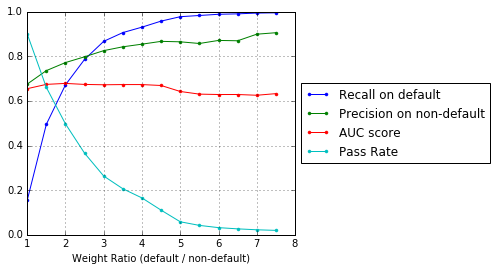

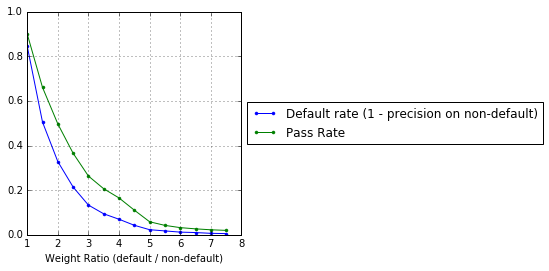

In [607]:
weights = np.arange(1.0, 8, 0.5)
pass_rates = []
accuracies = []
recall_on_1s = []
precision_on_0s = []
auc_scores = []
for weight in weights:
#     try:
    clf_slc = Logit(class_weight = {1:weight, 0:1.0})
    clf_slc.fit(X_train_sel, y_train)
    y_predict_slc = clf_slc.predict(X_test_sel)
    y_predict_prob_slc = clf_slc.predict_proba(X_test_sel)[:,1]
    pass_rate, accuracy, recall_on_1, precision_on_0 = predict_table(y_test, y_predict_slc)
    pass_rates.append(pass_rate)
    accuracies.append(accuracy)
    recall_on_1s.append(recall_on_1)
    precision_on_0s.append(precision_on_0)
    auc_score = roc_auc_score(y_test, y_predict_prob_slc)
    auc_scores.append(auc_score)
    
fig = plt.figure()
ax = fig.add_subplot(111)    
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.plot(weights, recall_on_1s, '.-',label = 'Recall on default')
ax.plot(weights, precision_on_0s, '.-',label = 'Precision on non-default')
# ax.plot(weights, accuracies, '.-',label = 'Accuracy')
ax.plot(weights, auc_scores, '.-',label = 'AUC score')
ax.plot(weights, pass_rates, '.-',label = 'Pass Rate')
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Weight Ratio (default / non-default)')
ax.grid('on')
plt.show()

fig = plt.figure()
ax1 = fig.add_subplot(111)    
box = ax.get_position()
ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])

default = [1 - i for i in recall_on_1s]
ax1.plot(weights, default, '.-',label = 'Default rate (1 - precision on non-default)')
ax1.plot(weights, pass_rates, '.-',label = 'Pass Rate')
# Put a legend to the right of the current axis
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))


plt.xlabel('Weight Ratio (default / non-default)')
plt.grid('on')
plt.show()

### 3.3.2 Adjust Threshold

In [532]:
def sigmoid(a):
    if(a > 15):
        return 0.99999999
    elif(a < -15):
        return 0.00000001
    else:
        return 1.0 / (1 + np.exp(-a))

def NewtonMethod(train_data, train_label):
    
    alpha = 0.01
    
    new_train_data = np.ones((len(train_data), 1), dtype = float)
    new_train_data = np.append(new_train_data, train_data, axis = 1)

    num_features = len(new_train_data[0])

    w_prev = np.zeros(num_features)

    
    y = np.array([sigmoid(np.dot(w_prev, new_train_data[i])) for i in range(len(new_train_data))])

    R = np.diag(np.multiply(y, 1- y))
    

    part1 = np.linalg.inv(alpha * np.identity(num_features) + np.dot(np.dot(new_train_data.transpose(), R), new_train_data))
    part2 = np.dot(new_train_data.transpose(), (y - train_label)) + alpha * w_prev

    w_next = w_prev - np.dot(part1, part2)


    count = 0

    while((count == 0) or ((count <= 100) and (np.linalg.norm(w_next - w_prev)/np.linalg.norm(w_prev) >= 0.001))):
        
        w_prev = w_next

        y = np.array([sigmoid(np.dot(w_prev, new_train_data[i])) for i in range(len(new_train_data))])
        R = np.diag(np.multiply(y, 1- y))
        
        part1 = np.linalg.inv(alpha * np.identity(num_features) + np.dot(np.dot(new_train_data.transpose(), R), new_train_data))
        part2 = np.dot(new_train_data.transpose(), (y - train_label)) + alpha * w_prev
        
        w_next = w_prev - np.dot(part1, part2)
        count += 1
    
    w0 = w_next[0]
    w = np.array(w_next[1:])
    return w0, w

def getPrediction(w0, w, test_data, test_label, threshold = 0.5):
    """
    Input: w0 and w are parameters from training data
    Return: predict accuracy on test dataset. 
    """
    y_pred = []
    for i in range(len(test_label)):
        predit = sigmoid(np.dot(w, test_data[i]) + w0) > threshold
        if(predit):
            y_pred.append(1.0)
        else:
            y_pred.append(0.0)
    return y_pred

def getProbability(w0, w, test_data, test_label, threshold = 0.5):
    y_prob = []
    for i in range(len(test_label)):
        predit = sigmoid(np.dot(w, test_data[i]) + w0) > threshold
        y_prob.append(predit)
    return y_prob

In [534]:
w0, w = NewtonMethod(X_train_sel, y_train)
thresholds = np.arange(0.05, 0.95, 0.05)
pass_rates = []
accuracies = []
recall_on_1s = []
precision_on_0s = []
auc_scores = []
for threshold in thresholds:
    y_predict_BLR = getPrediction(w0, w, X_test_sel.values, y_test, threshold)
    y_predict_prob_BLR = getProbability(w0, w, X_test_sel.values, y_test, threshold)
    pass_rate, accuracy, recall_on_1, precision_on_0 = predict_table(y_test, y_predict_BLR)
    pass_rates.append(pass_rate)
    accuracies.append(accuracy)
    recall_on_1s.append(recall_on_1)

    precision_on_0s.append(precision_on_0)
    auc_score = roc_auc_score(y_test, y_predict_prob_BLR)
    auc_scores.append(auc_score)

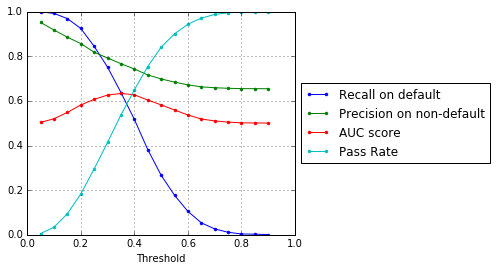

In [537]:
ax = plt.subplot(111)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])


ax.plot(thresholds, recall_on_1s, '.-',label = 'Recall on default')
ax.plot(thresholds, precision_on_0s, '.-',label = 'Precision on non-default')
# plt.plot(thresholds, accuracies, '.-',label = 'Accuracy')
ax.plot(thresholds, auc_scores, '.-',label = 'AUC score')
ax.plot(thresholds, pass_rates, '.-',label = 'Pass Rate')
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.xlabel('Threshold')
plt.grid('on')
plt.savefig('./poster/plots/threshold.png')

## 3.4 Suggestions to Lending Club

Right now Lending Club provides credit grade and subgrade to assist the investors in loan selections. The distribution of Lending Club grade and the default probability for each Lending Club grade are listed below:

Proportion of loans in each Lending Club credit grade:
A    0.117151
B    0.240927
C    0.292757
D    0.174843
E    0.110005
F    0.048137
G    0.016180
Name: grade, dtype: float64
Default rate for each Lending Club credit grade:
A    0.139822
B    0.245292
C    0.343527
D    0.433525
E    0.512409
F    0.555463
G    0.615385
Name: grade, dtype: float64


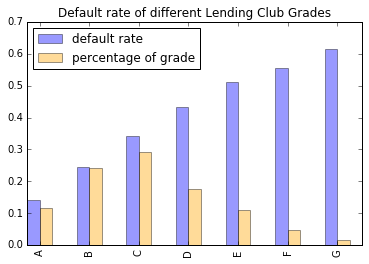

In [617]:
grade_non_default = data[y == 0].grade.copy()
grade_non_default = grade_non_default.value_counts().sort_index()

grade_default = data[y == 1].grade.copy()
grade_default = grade_default.value_counts().sort_index()


grade = data.grade.copy().value_counts().sort_index()
grade_proportion = grade /data.shape[0]
print "Proportion of loans in each Lending Club credit grade:"
print grade/data.shape[0]
default_rate = (grade_default) / grade
print "Default rate for each Lending Club credit grade:"
print default_rate
default_rate.plot(kind='bar', color = 'blue', alpha = 0.4, position=1, width=0.25,label = 'default rate')
grade_proportion.plot(kind='bar', color = 'orange', alpha = 0.4, position=0, width=0.25,label = 'percentage of grade')
plt.legend(loc = 'best')
plt.title('Default rate of different Lending Club Grades')
plt.show()

# Future Work